In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
#!pip install scikit-plot
import scikitplot as skplt
import networkx as nx

import warnings
warnings.filterwarnings('ignore')

## Part II: Finding Influencers from Twitter

#### code that scrapes tweets off of twitter and puts them in a dataframe

In [ ]:
import tweepy
from tweepy import OAuthHandler
import json
import pandas as pd
import time

consumer_key = 'tL3VuPEVIiC9vEeA68QKxXXUJ'
consumer_secret = 'IaB7wLGsQUgwrDzoJtSqFsCyoE20tBof568A5A5DtoaxIjlas2'
access_token = '441978197-svKC16MZCmSAtrx5YGVPVqFUdSOUTgtEyrZ97ATn'
access_secret = 'gDHMW67mr7Ioe9wIUOr3AEFLIz1uVv6yP2ruOopiKc4yc'

maximum_number_of_tweets_to_be_extracted = int(input('Enter the number of tweets that you want to extract- '))

# Mention the hashtag that you want to look out for

hashtag = input('Enter the hashtag you want to scrape- ')
 
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

message,favorite_count,retweet_count,created_at,user_name,favourites_count,description,friends_count,followers_count=[],[],[],[],[],[],[],[],[]

statuses = tweepy.Cursor(api.search, q='#' + hashtag, rpp=100).items(maximum_number_of_tweets_to_be_extracted)

for status in statuses:
    message.append(status.text)
    favorite_count.append(status.favorite_count)
    retweet_count.append(status.retweet_count)
    created_at.append(status.created_at)
    user_name.append(status.user.screen_name)
    favourites_count.append(status.user.favourites_count)
    description.append(status.user.description)
    friends_count.append(status.user.friends_count)
    followers_count.append(status.user.followers_count)
    time.sleep(0.3)

df = pd.DataFrame({'Message':message,
                'Tweet Favorite Count':favorite_count,
                'Retweet Count':retweet_count,
                'Created At':created_at,
                'Username':user_name,
                'Likes':favourites_count,
                'User Description':description,
                'Following':friends_count,
                'Followers':followers_count})

df.to_csv("Twitter Timeline.csv")

Enter the number of tweets that you want to extract- 5000
Enter the hashtag you want to scrape- #antivaxx


### Modify the tweet data to match the format for network creation.

In [ ]:
data = pd.read_csv('Twitter Timeline.csv', encoding = 'latin1')
data.head()

,Unnamed: 0,Message,Tweet Favorite Count,Retweet Count,Created At,Username,Likes,User Description,Following,Followers
0,0,RT @wqbelle: #Covid: What if the U.S. was comp...,0,3,2022-02-04 18:03:25,wqbelle,1280,just on a whim\n\nAmazon https://t.co/aoYR4Sf7eF,18,624
1,1,RT @wqbelle: #Covid: What if I compared the U....,0,1,2022-02-04 18:03:13,wqbelle,1280,just on a whim\n\nAmazon https://t.co/aoYR4Sf7eF,18,624
2,2,RT @cathy91540: #antivaxx https://t.co/dajvP15Vio,0,1,2022-02-04 17:57:31,pige16,8294,retraitÃ© de l'industrie (metallurgie).,176,149
3,3,RT @davemacladd: well that was a very interest...,0,16,2022-02-04 17:45:07,jimoatway,47770,NaN,451,154
4,4,RT @wqbelle: Covid: The Premise of the Anti's\...,0,2,2022-02-04 17:44:54,wqbelle,1280,just on a whim\n\nAmazon https://t.co/aoYR4Sf7eF,18,624


In [ ]:
# Define a function to find users whose tweets were retweeted
import re

def find_retweet(s):
    retweet = re.findall('RT \@[^\s\:]+',s)
    try:
        retweet = retweet[0][4:]
    except IndexError:
        retweet = None
    return retweet

In [ ]:
column_1 = data['Username']
column_2 = data['Message'].map(find_retweet)
tweet_data = pd.concat([column_1, column_2], axis=1)
tweet_data['Interaction'] = tweet_data['Message'].apply(lambda x: 'Retweet' if x != None else 'Tweet')
tweet_data['Message'] = tweet_data.apply(lambda row: row['Username'] if row['Message'] == None else row['Message'],axis=1)

tweet_data.columns = ['User_A', 'User_B', 'Interaction']
tweet_data.head()

,User_A,User_B,Interaction
0,wqbelle,wqbelle,Retweet
1,wqbelle,wqbelle,Retweet
2,pige16,cathy91540,Retweet
3,jimoatway,davemacladd,Retweet
4,wqbelle,wqbelle,Retweet


In [ ]:
# Output CSV file

tweet_data.to_csv('SMA_Assignment_1.csv')

### Create the visualization of the network using networkx

In [ ]:
tweet_data['nodes'] = tweet_data[['User_A', 'User_B']].apply(tuple, axis=1)

g = nx.DiGraph()  
g.add_edges_from(tweet_data['nodes'])

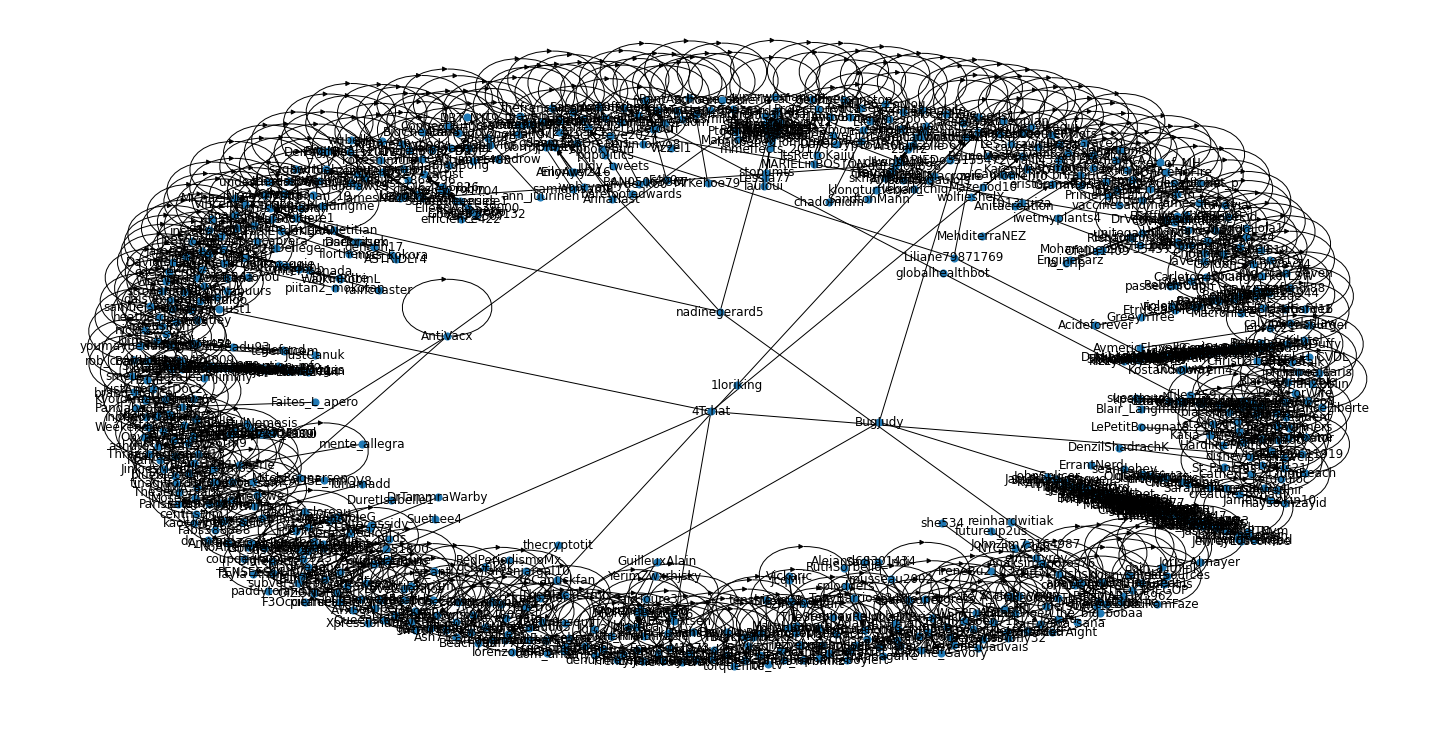

In [ ]:
plt.figure(figsize = (20, 10))

nx.draw(g, with_labels = True, node_size = 50, font_size = 12)  
plt.show()  

Next, lets use the data to calculate measures of centrality - Degree, Betweenness and Closeness

In [ ]:
degree = nx.degree_centrality(g)
between = nx.betweenness_centrality(g)
close = nx.closeness_centrality(g)

In [ ]:
df = pd.DataFrame([degree, between,close]).T
df.reset_index(inplace = True)
df.columns = ['Username','degree','between','close']
df.head()

,Username,degree,between,close
0,wqbelle,0.004745,0.0,0.002372
1,pige16,0.001186,0.0,0.000000
2,cathy91540,0.001186,0.0,0.001186
3,jimoatway,0.001186,0.0,0.000000
4,davemacladd,0.037960,0.0,0.035587


In [ ]:
data.merge(df,how = 'inner',left_on='Username',right_on = 'Username').head()

,Unnamed: 0,Message,Tweet Favorite Count,Retweet Count,Created At,Username,Likes,User Description,Following,Followers,degree,between,close
0,0,RT @wqbelle: #Covid: What if the U.S. was comp...,0,3,2022-02-04 18:03:25,wqbelle,1280,just on a whim\n\nAmazon https://t.co/aoYR4Sf7eF,18,624,0.004745,0.0,0.002372
1,1,RT @wqbelle: #Covid: What if I compared the U....,0,1,2022-02-04 18:03:13,wqbelle,1280,just on a whim\n\nAmazon https://t.co/aoYR4Sf7eF,18,624,0.004745,0.0,0.002372
2,4,RT @wqbelle: Covid: The Premise of the Anti's\...,0,2,2022-02-04 17:44:54,wqbelle,1280,just on a whim\n\nAmazon https://t.co/aoYR4Sf7eF,18,624,0.004745,0.0,0.002372
3,5,RT @wqbelle: Covid-19: What would you do? \n\n...,0,2,2022-02-04 17:44:49,wqbelle,1280,just on a whim\n\nAmazon https://t.co/aoYR4Sf7eF,18,624,0.004745,0.0,0.002372
4,6,RT @wqbelle: Dear #Antivaxxers: What about my ...,0,17,2022-02-04 17:44:45,wqbelle,1280,just on a whim\n\nAmazon https://t.co/aoYR4Sf7eF,18,624,0.004745,0.0,0.002372


In [ ]:
sma_assign_1 = pd.read_csv('SMA_Assignment_1.csv')

#removes the first useless column
sma_assign_1 = sma_assign_1.iloc[:, 1:] 

#get retweet_sent counts, tweet counts and retweets_received counts

user_a_retweets_tweets = pd.pivot_table(sma_assign_1, index = 'User_A', columns = 'Interaction', 
                                        aggfunc = "count", fill_value = 0).reset_index()

user_a_retweets_tweets.columns = user_a_retweets_tweets.columns.get_level_values(0)

user_a_retweets_tweets.columns = ['User_Name', 'Retweets_sent','tweet_count']

In [ ]:
user_b_retweets_rec = pd.pivot_table(sma_assign_1, index = 'User_B', columns = 'Interaction', 
                                     aggfunc = "count", fill_value = 0).reset_index()

user_b_retweets_rec.columns = user_b_retweets_rec.columns.get_level_values(0)
user_b_retweets_rec.columns = ['User_Name', 'Retweets_rec','tweet_count']

user_b_retweets_rec.drop('tweet_count', inplace = True, axis = 1)

# merge the two for the final results
data2 = user_a_retweets_tweets.merge(user_b_retweets_rec, how = 'outer', 
                                     left_on = 'User_Name', right_on = 'User_Name').fillna(0)

In [ ]:
# merge with other user data
final_df = data[['Username', 'Following', 'Followers']].drop_duplicates().merge(data2, how = 'left', 
                                                      left_on = 'Username', right_on = 'User_Name')

final_df.drop('User_Name', axis = 1, inplace = True)

final_df.head()

,Username,Following,Followers,Retweets_sent,tweet_count,Retweets_rec
0,wqbelle,18,624,12.0,2.0,22.0
1,pige16,176,149,1.0,0.0,0.0
2,jimoatway,451,154,1.0,0.0,0.0
3,caf_goodness,595,438,0.0,1.0,0.0
4,Eilonwy24,249,529,1.0,0.0,0.0


**Standardizing the variables** 


In [ ]:
for i in final_df.iloc[:, 1:]:
  
    mean = final_df[i].mean()
    std = final_df[i].std()
    
    final_df[i] -= mean
    final_df[i] /= std

In [ ]:
final_df.drop_duplicates(inplace=True)

# merge network stats with twitter stats
final_df2 = df.merge(final_df, on = "Username")

var_coefficients

follower_ratio         6.895888
mentions_rec_ratio     0.143677
network_1              0.385637
network_2              0.207118
mentions_sent_ratio    0.690370
posts_ratio            0.118623
dtype: float64

In [ ]:
final_df2['Score'] = final_df2['Followers']*var_coefficients[0] + \
                     final_df2['Retweets_rec']*var_coefficients[1] + \
                     final_df2['degree']*var_coefficients[2] + \
                     final_df2['between']*var_coefficients[3] + \
                     final_df2['Retweets_sent']*var_coefficients[4] + \
                     final_df2['tweet_count']*var_coefficients[5]

In [ ]:
# These are the Top 50 influencers using a score calculated by multiplying 
# the logistic regression coefficients to the appropriate twitter stats

final_df2.drop_duplicates(subset='Username',inplace=True)
final_df2.sort_values(by='Score', ascending=False)[:50]

,Username,degree,between,close,Following,Followers,Retweets_sent,tweet_count,Retweets_rec,Score
51,NormOrnstein,0.001186,0.0,0.000000,0.532381,19.525624,0.371804,-0.483490,-0.143085,134.825739
142,SaraJBenincasa,0.001186,0.0,0.000000,7.976193,10.324091,0.371804,-0.483490,-0.143085,71.373000
466,KiIntel,0.003559,0.0,0.001186,-0.501228,9.362875,-0.591778,0.273195,0.128912,64.209087
3,davemacladd,0.037960,0.0,0.035587,17.675069,8.952535,-0.591778,1.029880,8.288829,62.654847
768,BrunoMasure,0.002372,0.0,0.000000,0.005682,5.123274,-0.591778,0.273195,-0.143085,34.933743
138,arthur_affect,0.001186,0.0,0.000000,-0.183686,4.114185,0.371804,-0.483490,-0.143085,28.550189
416,lsiafrica,0.009490,0.0,0.007117,-0.138018,3.854689,-0.591778,0.273195,1.488898,26.422942
18,michaelcoren,0.088968,0.0,0.086595,-0.460736,3.099028,-0.591778,3.299935,21.344696,24.454496
338,Drmartyufml,0.008304,0.0,0.005931,0.567698,3.393875,-0.591778,0.273195,1.216901,23.205686
29,maysoonzayid,0.016607,0.0,0.014235,3.664567,2.860337,0.371804,0.273195,3.392879,20.507536
